In [1]:
import sys
sys.path.append("../../../")

## 数据

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pylib.utils.functions_for_classification import lin_separable_2d_3cls, plot_scatter

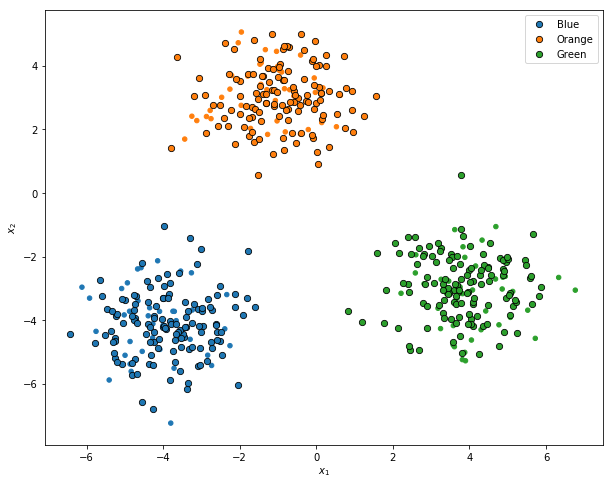

In [3]:
X_train, X_test, y_train, y_test = lin_separable_2d_3cls(500)

plt.figure(figsize=(10, 8))
plot_scatter(X_train, y_train, X_test, y_test)
plt.show()

## L1正则化逻辑斯蒂回归

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from pylib.utils.functions_for_classification import plot_decision_boundary
from sklearn.multiclass import OneVsOneClassifier
import numpy as np

In [7]:
class LogisticRegression(BaseEstimator, ClassifierMixin):
    """逻辑斯蒂回归
    
    参数
    ----
    alpha: L1正则化
    learning_rate: 在梯度下降中，更新权重所用的步长
    max_iter: 在梯度下降中，所用迭代的最大步数
    W0: 权重初始值，默认为None，即使用随机初始化
    random_state: 随机数生成器的种子
    
    
    属性
    ----
    W: 最终迭代后的权重
    weight_history: 记录权重值
    loss_history: 记录损失值
    """
    def __init__(self, alpha=1.0, learning_rate=0.5, max_iter=500, 
                 W0=None, random_state=None):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.W0 = W0
        self.seed = random_state
    
    # S型函数
    def __sigmoid_function(self, X, W):
        return 1 / (1 + np.exp(-X @ W))
    
    # 交叉熵成本函数
    def __l1_regularized_cross_entropy_cost(self, X, W, y):
        y_pred0 = self.__sigmoid_function(X[y == 0], W)
        y_pred1 = self.__sigmoid_function(X[y == 1], W)
        tol = 1e-8
        cost = 1/len(y) * (-np.sum(np.log(1 - y_pred0 + tol)) - \
                           np.sum(np.log(y_pred1 + tol))) + self.alpha * np.sum(np.abs(W))

        return cost
    
    def __coordinate_descent(self, X, W, y):
        np.random.seed(self.seed)
        p = X.shape[1]
        weight_history = [W.copy()] 
        loss = self.__l1_regularized_cross_entropy_cost(X, W, y)
        loss_history = [loss]  
        tol = 1e-5
        for i in range(1, self.max_iter + 1):
            c = np.random.permutation(p)  # 对坐标随机洗牌
            
            # 循环遍历每个坐标
            for j in range(p):
                direction = np.zeros(p)
                direction[c[j]] = 1

                if i > 1: 
                    weight_diff = np.abs(np.sum(np.abs(weight_history[-1]) - np.abs(weight_history[-2])))
                    if weight_diff < tol:
                        return weight_history, loss_history

                # 估计并比较两个坐标方向上的损失值
                evals = []
                direction1 = W + self.learning_rate * direction
                direction2 = W - self.learning_rate * direction
                evals.append(self.__l1_regularized_cross_entropy_cost(X, direction1, y))  
                evals.append(self.__l1_regularized_cross_entropy_cost(X, direction2, y)) 
                evals = np.array(evals)

                ind = np.argmin(evals)  #  找到损失值最小的坐标方向索引
                if evals[ind] < loss_history[-1]:
                    W = W + ((-1) ** (ind)) * self.learning_rate * direction # 权重更新公式
                    loss = evals[ind]
            weight_history.append(W.copy())
            weight_change = np.sum(np.abs(np.abs(weight_history[-1]) - \
                                      np.abs(weight_history[-2])))
            if weight_change < tol:
                break
            loss_history.append(loss)
        if weight_change > tol:
            print("Logistic regression dosen't converge!")
        
        return weight_history, loss_history
    
    def fit(self, X, y=None):
        np.random.seed(self.seed)
        X = np.c_[np.ones(len(X)), X]
        p = X.shape[1]
        if self.W0 != None:
            W = self.W0
        else:
            # 随机初始化权重
            W = np.random.randn(p)
        self.weight_history, self.loss_history = self.__coordinate_descent(X, W, y)
        self.W = self.weight_history[-1]
        
        return self
    
    def predict_proba(self, X):
        X = np.c_[np.ones(len(X)), X]
        y_proba = self.__sigmoid_function(X, self.W)
        
        return np.c_[y_proba, -y_proba]
    
    def predict(self, X):
        y_proba = self.predict_proba(X)[:, 0]
        y_pred = np.where(y_proba >= 0.5, 1, 0)
        
        return y_pred

### 当$\alpha=0.1$时

In [8]:
multi_logreg1 = OneVsOneClassifier(
    LogisticRegression(alpha=0.1, random_state=42),
    n_jobs=-1)
multi_logreg1.fit(X_train, y_train)

E:\a-soft\Anaconda3\envs\mlproduct\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


OneVsOneClassifier(estimator=LogisticRegression(alpha=0.1), n_jobs=-1)

In [9]:
train_err = 1 - multi_logreg1.score(X_train, y_train)
print("训练样本误差：{:.3f}".format(train_err))

训练样本误差：0.000


In [10]:
test_err = 1 - multi_logreg1.score(X_test, y_test)
print("测试样本误差：{:.3f}".format(test_err))

测试样本误差：0.000


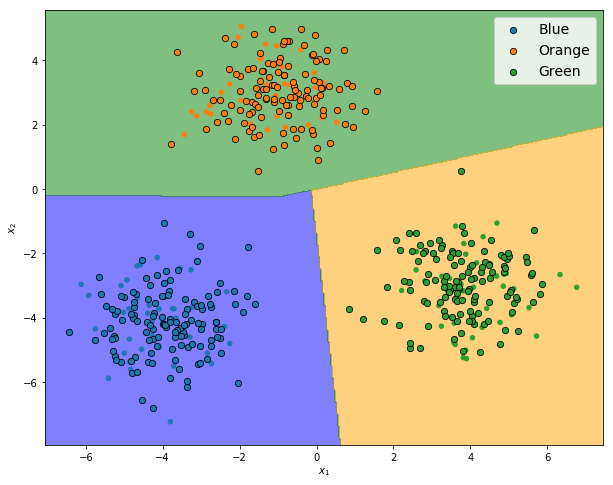

In [11]:
# 画出决策边界
plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, 
                       classifier=multi_logreg1)
plt.show()

### 当$\alpha=1.0$时

In [27]:
multi_logreg2 = OneVsOneClassifier(
    LogisticRegression(alpha=1., random_state=42),
    n_jobs=-1)
multi_logreg2.fit(X_train, y_train)

E:\a-soft\Anaconda3\envs\mlproduct\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


OneVsOneClassifier(estimator=LogisticRegression(), n_jobs=-1)

In [28]:
train_err = 1 - multi_logreg2.score(X_train, y_train)
print("训练样本误差：{:.3f}".format(train_err))

训练样本误差：0.019


In [29]:
test_err = 1 - multi_logreg2.score(X_test, y_test)
print("测试样本误差：{:.3f}".format(test_err))

测试样本误差：0.024


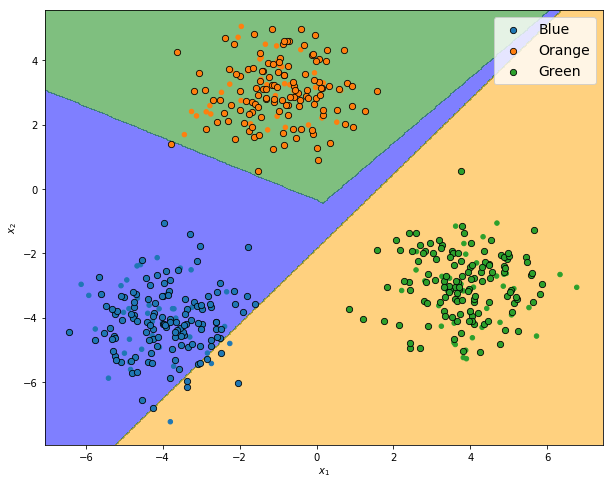

In [30]:
# 画出决策边界
plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, 
                       classifier=multi_logreg2)
plt.show()